# Book Data Linkage Statistics

This notebook presents statistics of the book data integration.

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Compute Link Stats

Let's compute linkage statistics from our data!

We are first going to define our gender codes.  We'll start with the resolved codes:

In [8]:
link_codes = ['female', 'male', 'ambiguous', 'unknown']

We want the unlink codes in order, so the last is the first link failure:

In [9]:
unlink_codes = ['no-author-rec', 'no-book-author', 'no-book']

Now we can load gender data:

In [12]:
viaf_genders = pd.read_parquet('book-links/cluster-genders.parquet')
viaf_genders = viaf_genders.set_index('cluster')['gender']
viaf_genders = viaf_genders.astype('category')
viaf_genders.cat.add_categories('no-book', inplace=True)
viaf_genders.cat.reorder_categories(link_codes + unlink_codes, inplace=True)
viaf_genders.describe()

count           27456006
unique                 6
top       no-book-author
freq            18556078
Name: gender, dtype: object

In [14]:
isbn_clusters = pd.read_parquet('book-links/isbn-clusters.parquet')
isbn_clusters = isbn_clusters.set_index('isbn_id')['cluster']
isbn_clusters

isbn_id
8192        107985306
1535270     107985306
34895       107985306
1544287     107985306
14361445    107985306
              ...    
24503756    421833421
24503757    416168734
24503758    418243823
24503760    924503760
24503761    419058241
Name: cluster, Length: 24503761, dtype: int32

Define a variable to store all of these:

In [24]:
source_stats = {}

### LOC book corpus

In [15]:
loc_isbns = pd.read_parquet('loc-mds/book-isbn-ids.parquet')
loc_clusters = loc_isbns.join(isbn_clusters, on='isbn_id')
loc_clusters

,rec_id,isbn_id,cluster
0,6668210,1099,306668210
1,2031934,1195,111653002
2,4929131,1424,108941332
3,1998335,1605,107690969
4,2173918,1632,112319582
...,...,...,...
7763013,6167000,23511157,108356850
7763014,6585760,23511162,105814132
7763015,7010522,23511182,108913038
7763016,7010774,23511192,108773582


In [17]:
loc_genders = loc_clusters.join(viaf_genders, on='cluster', how='left')
loc_genders

,rec_id,isbn_id,cluster,gender
0,6668210,1099,306668210,male
1,2031934,1195,111653002,male
2,4929131,1424,108941332,male
3,1998335,1605,107690969,no-book-author
4,2173918,1632,112319582,female
...,...,...,...,...
7763013,6167000,23511157,108356850,male
7763014,6585760,23511162,105814132,no-author-rec
7763015,7010522,23511182,108913038,no-author-rec
7763016,7010774,23511192,108773582,male


In [34]:
loc_stats = loc_genders.groupby('gender')['rec_id'].count()
loc_stats = loc_stats.to_frame('n_books')
loc_stats

,n_books
gender,
female,1085968
male,3348804
ambiguous,124813
unknown,1646571
no-author-rec,384575
no-book-author,1172287
no-book,0


In [35]:
source_stats['LOC-MDS'] = loc_stats

### BookCrossing

We want to process action genders.  Each action frame will have an 'item' column that we use - let's define a helper function:

In [32]:
def action_stats(df):
    joined = df.join(viaf_genders, on='item', how='left')
    joined['gender'].fillna('no-book', inplace=True)
    return joined.groupby('gender')['item'].agg(['nunique', 'count']).rename(columns={
        'nunique': 'n_books',
        'count': 'n_actions'
    })

Do the implicit actions:

In [27]:
bx_actions = pd.read_parquet('bx/bx-cluster-actions.parquet')
bx_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128998 entries, 0 to 1128997
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   user      1128998 non-null  int64 
 1   item      1128998 non-null  int32 
 2   nactions  1128998 non-null  uint64
dtypes: int32(1), int64(1), uint64(1)
memory usage: 21.5 MB


In [33]:
bx_act_stats = action_stats(bx_actions)
bx_act_stats

,n_books,n_actions
gender,,
female,67032,388074
male,97858,464561
ambiguous,7125,80623
unknown,34769,77991
no-author-rec,14001,23288
no-book-author,56967,87925
no-book,969,6536


In [36]:
source_stats['BX-I'] = bx_act_stats

And now we do ratings:

In [37]:
bx_ratings = pd.read_parquet('bx/bx-cluster-ratings.parquet')
bx_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427122 entries, 0 to 427121
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user      427122 non-null  int64  
 1   item      427122 non-null  int32  
 2   rating    427122 non-null  float32
 3   nratings  427122 non-null  uint64 
dtypes: float32(1), int32(1), int64(1), uint64(1)
memory usage: 9.8 MB


In [38]:
bx_rate_stats = action_stats(bx_ratings)
bx_rate_stats

,n_books,n_actions
gender,,
female,37984,137395
male,56291,183505
ambiguous,4194,32517
unknown,16988,27530
no-author-rec,6872,8751
no-book-author,28336,34826
no-book,667,2598


In [39]:
source_stats['BX-E'] = bx_rate_stats

### Amazon data

Let's process the Amazon data:

In [ ]:
az_ratings = pd.read_parquet('bx/bx-cluster-actions.parquet')
az_ratings.info()

### Integrating Statistics

Time to integrate all of these:

In [40]:
link_stats = pd.concat(source_stats, names=['dataset'])
link_stats

n_books  n_actions
dataset gender                            
LOC-MDS female          1085968        NaN
        male            3348804        NaN
        ambiguous        124813        NaN
        unknown         1646571        NaN
        no-author-rec    384575        NaN
        no-book-author  1172287        NaN
        no-book               0        NaN
BX-I    female            67032   388074.0
        male              97858   464561.0
        ambiguous          7125    80623.0
        unknown           34769    77991.0
        no-author-rec     14001    23288.0
        no-book-author    56967    87925.0
        no-book             969     6536.0
BX-E    female            37984   137395.0
        male              56291   183505.0
        ambiguous          4194    32517.0
        unknown           16988    27530.0
        no-author-rec      6872     8751.0
        no-book-author    28336    34826.0
        no-book             667     2598.0

Now we'll pivot each of our count columns into a table for easier reference.

In [62]:
book_counts = link_stats['n_books'].unstack()
book_counts.sort_index(inplace=True)
book_counts

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
BX-E,37984,56291,4194,16988,6872,28336,667
BX-I,67032,97858,7125,34769,14001,56967,969
LOC-MDS,1085968,3348804,124813,1646571,384575,1172287,0


In [63]:
act_counts = link_stats['n_actions'].unstack()
act_counts.drop(index='LOC-MDS', inplace=True)
act_counts.sort_index(inplace=True)
act_counts

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
BX-E,137395.0,183505.0,32517.0,27530.0,8751.0,34826.0,2598.0
BX-I,388074.0,464561.0,80623.0,77991.0,23288.0,87925.0,6536.0


We're going to want to compute versions of this table as fractions, e.g. the fraction of books that are written by women.  We will use the following helper function:

In [64]:
def fractionalize(data, columns, unlinked=None):
    fracs = data[columns]
    fracs.columns = fracs.columns.astype('str')
    if unlinked:
        fracs = fracs.assign(unlinked=data[unlinked].sum(axis=1))
    totals = fracs.sum(axis=1)
    return fracs.divide(totals, axis=0)

And a helper function for plotting bar charts:

In [65]:
def plot_bars(fracs, ax=None, cmap=mpl.cm.Dark2):
    if ax is None:
        ax = plt.gca()
    size = 0.5
    ind = np.arange(len(fracs))
    start = pd.Series(0, index=fracs.index)
    for i, col in enumerate(fracs.columns):
        vals = fracs.iloc[:, i]
        rects = ax.barh(ind, vals, size, left=start, label=col, color=cmap(i))
        for j, rec in enumerate(rects):
            if vals.iloc[j] < 0.1 or np.isnan(vals.iloc[j]): continue
            y = rec.get_y() + rec.get_height() / 2
            x = start.iloc[j] + vals.iloc[j] / 2
            ax.annotate('{:.1f}%'.format(vals.iloc[j] * 100),
                        xy=(x,y), ha='center', va='center', color='white',
                        fontweight='bold')
        start += vals.fillna(0)
    ax.set_xlabel('Fraction of Books')
    ax.set_ylabel('Data Set')
    ax.set_yticks(ind)
    ax.set_yticklabels(fracs.index)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Resolution of Books

What fraction of *unique books* are resolved from each source?

In [66]:
fractionalize(book_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
BX-E,0.250998,0.371970,0.027714,0.112256,0.045410,0.187244,0.004408
BX-I,0.240499,0.351097,0.025563,0.124745,0.050233,0.204387,0.003477
LOC-MDS,0.139890,0.431379,0.016078,0.212104,0.049539,0.151009,0.000000


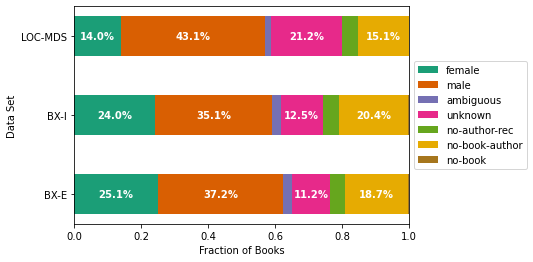

In [67]:
plot_bars(fractionalize(book_counts, link_codes + unlink_codes))

In [68]:
fractionalize(book_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
BX-E,0.250998,0.371970,0.027714,0.112256,0.237062
BX-I,0.240499,0.351097,0.025563,0.124745,0.258097
LOC-MDS,0.139890,0.431379,0.016078,0.212104,0.200549


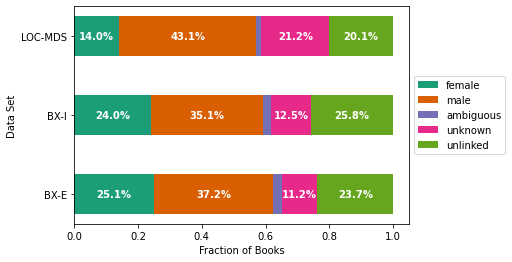

In [69]:
plot_bars(fractionalize(book_counts, link_codes, unlink_codes))

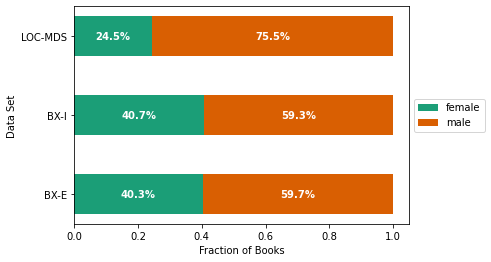

In [70]:
plot_bars(fractionalize(book_counts, ['female', 'male']))

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?

In [71]:
fractionalize(act_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
BX-E,0.321676,0.429631,0.076130,0.064455,0.020488,0.081536,0.006083
BX-I,0.343733,0.411481,0.071411,0.069080,0.020627,0.077879,0.005789


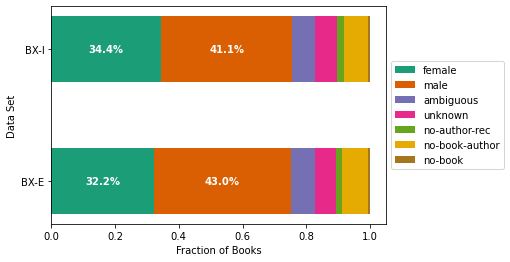

In [72]:
plot_bars(fractionalize(act_counts, link_codes + unlink_codes))

In [55]:
fractionalize(act_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
BX-I,0.343733,0.411481,0.071411,0.069080,0.104295
BX-E,0.321676,0.429631,0.076130,0.064455,0.108107


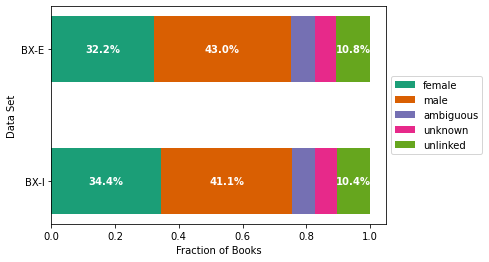

In [56]:
plot_bars(fractionalize(act_counts, link_codes, unlink_codes))

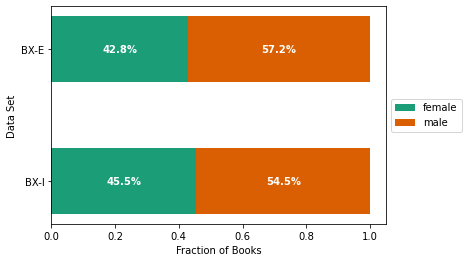

In [57]:
plot_bars(fractionalize(act_counts, ['female', 'male']))